In [1]:
import numpy as np
import scipy
from scipy.optimize import minimize

# ------------------------
# Basic Pauli operators
# ------------------------
X = np.array([[0, 1],
              [1, 0]], dtype=complex)

Y = np.array([[0, -1j],
              [1j, 0]], dtype=complex)

def B(phi, theta):
    """
    Entangling gate:
    U2 @ U1 with rotated Pauli operators.
    """
    sigma_phi  = np.cos(phi) * X + np.sin(phi) * Y
    sigma_mphi = np.cos(phi) * X - np.sin(phi) * Y # spin echo!

    U1 = scipy.linalg.expm(-1j * theta * np.kron(sigma_phi,  sigma_phi))
    U2 = scipy.linalg.expm(-1j * theta * np.kron(sigma_mphi, sigma_mphi))

    return U1@U2


# ------------------------
# Single-qubit U3 gate
# (standard parameterization: θ, φ, λ)
# ------------------------
def U3(theta, phi, lam):
    """
    U3(θ, φ, λ) single-qubit gate (like Qiskit).
    Up to a global phase, this spans all SU(2).
    """
    c = np.cos(theta / 2.0)
    s = np.sin(theta / 2.0)

    return np.array([
        [c,            -np.exp(1j * lam) * s],
        [np.exp(1j*phi) * s, np.exp(1j * (phi + lam)) * c]
    ], dtype=complex)


# ------------------------
# Random SU(4) generator
# ------------------------
def random_su4(seed=None):
    """
    Generate a random 4x4 unitary with det=1 (SU(4))
    via QR decomposition of a Ginibre (complex Gaussian) matrix.
    """
    rng = np.random.default_rng(seed)
    A = rng.normal(size=(4, 4)) + 1j * rng.normal(size=(4, 4))
    Q, R = np.linalg.qr(A)
    # Enforce unit-modulus diagonal of R to make Q unitary
    phases = np.diag(R) / np.abs(np.diag(R))
    Q = Q * phases

    # Fix determinant to 1 (SU(4) not just U(4))
    det_Q = np.linalg.det(Q)
    Q /= det_Q ** (1 / 4.0)

    return Q


# ------------------------
# Ansatz construction
# ------------------------
def build_ansatz(params):
    """
    params is a 22D vector:
    [0]  phi1
    [1]  theta1
    [2]  phi2
    [3]  theta2

    [4:7]   A1 (θ, φ, λ)
    [7:10]  B1 (θ, φ, λ)
    [10:13] A2 (θ, φ, λ)
    [13:16] B2 (θ, φ, λ)
    [16:19] A3 (θ, φ, λ)
    [19:22] B3 (θ, φ, λ)
    """

    phi1, theta1, phi2, theta2 = params[0:4]

    A1 = U3(*params[4:7])
    B1 = U3(*params[7:10])
    A2 = U3(*params[10:13])
    B2 = U3(*params[13:16])
    A3 = U3(*params[16:19])
    B3 = U3(*params[19:22])

    M1 = B(phi1, theta1)
    M2 = B(phi2, theta2)

    # Full 2-qubit ansatz:
    # (A3⊗B3) · M2 · (A2⊗B2) · M1 · (A1⊗B1)
    U = np.kron(A3, B3) @ M2 @ np.kron(A2, B2) @ M1 @ np.kron(A1, B1)
    return U


# ------------------------
# Fidelity-based cost
# ------------------------
def gate_fidelity(U, V):
    """
    Global-phase-insensitive gate fidelity proxy:
    F = |Tr(U† V)| / d
    where d = 4 for 2 qubits.
    """
    d = U.shape[0]
    return np.abs(np.trace(U.conj().T @ V)) / d

def cost(params, U_target):
    U = build_ansatz(params)
    F = gate_fidelity(U, U_target)
    # Minimize 1 - F
    return 1.0 - F.real

# ------------------------
# Optimization wrapper
# ------------------------
def optimize_for_target(U_target, seed=None, params=22):
    """
    Optimize ansatz parameters to approximate a given 2-qubit unitary U_target.
    Returns (opt_params, final_fidelity, result_object).
    """
    rng = np.random.default_rng(seed)

    # 22 parameters: initialize near zero with small random noise
    init = 0.1 * rng.normal(size=params)

    # Optional: you can bound angles, e.g., [-2π, 2π]
    two_pi = 2 * np.pi
    bounds = [(-two_pi, two_pi)] * params

    res = minimize(
        fun=cost,
        x0=init,
        args=(U_target,),
        method="L-BFGS-B",
        bounds=bounds,
        options={"maxiter": 10000, "ftol": 1e-20}
    )

    params_opt = res.x
    final_F = 1.0 - res.fun

    return params_opt, final_F, res


if __name__ == "__main__":
    # ------------------------
    # Example: random SU(4) target
    # ------------------------
    #U_target = random_su4(seed=123)
    U_target = np.array([[ 0.0254+0.218j , -0.1856-0.3222j, -0.177 +0.7081j,
        -0.4702+0.2445j],
       [ 0.4492+0.0913j, -0.7604+0.1589j, -0.2957-0.186j ,
        -0.0411-0.2504j],
       [ 0.3109+0.2041j,  0.2161+0.038j , -0.53  +0.0035j,
         0.4872+0.5434j],
       [ 0.6073-0.4844j,  0.216 -0.4043j,  0.0774-0.2416j,
        -0.3198+0.1407j]])

    params_opt, F_opt, res = optimize_for_target(U_target, seed=42)

    print("Optimization success:", res.success)
    print("Message:", res.message)
    print("Final gate fidelity ~", F_opt)

    print("\nOptimal parameters (length = {}):".format(len(params_opt)))
    print(params_opt)

    # (Optional) verify ansatz unitary vs target
    U_ans = build_ansatz(params_opt)
    #print("\nCheck unitarity of ansatz: ||U†U - I||_F =",
    #      np.linalg.norm(U_ans.conj().T @ U_ans - np.eye(4)))
    print("Check overlap with target: infidelity =", 1-gate_fidelity(U_ans, U_target))


Optimization success: True
Message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
Final gate fidelity ~ 1.0000061587510458

Optimal parameters (length = 22):
[-0.02077177 -0.50846397  0.58390112  0.59872933 -0.15598344  0.38314614
 -0.0048218   0.33701876 -0.15552763 -0.44785256 -0.3194139   1.49948434
  0.16847495  1.42324643  0.39614828  0.46693363 -0.94490788  0.26039995
 -0.16766224 -0.08645551  0.21278155  0.15607038]
Check overlap with target: infidelity = -6.158751045814981e-06


In [4]:
import numpy as np

import sys
sys.path.append("../../src/B-Gate")
from MS import averaged_ms_fidelity



if __name__ == "__main__":
    reps, phases = 2, (0, np.pi)
    
    eta=0.06
    Omega=2*np.pi*100e3
    delta=2*eta*Omega*np.sqrt(reps)
    print("Gate time: ", 1e6*2*np.pi/delta, "us")

    T1=1
    T2=200e-3
    heating_rate=1 

    det_error_frac = 3e-2
    z_sigma=2*np.pi*50 #(Assumes circa 100 Hz B-Field fluct.)
    # The higher this ratio of: "det_error_frac/z_sigma", the better it is to do 2-loop
    
    
    F_mean, F_std = averaged_ms_fidelity(
        n_states=10, Nmode=10,
        nsteps=100, n_zshots=20,
        
        eta=eta,
        Omega=Omega,
        delta=delta,
        T1=T1, T2=T2,
        detuning_error=det_error_frac*delta,
        heating_rate=heating_rate, z_sigma=z_sigma,
        correlated=False,

        reps=reps, phases=phases
    )

    print(f"Average MS gate fidelity: {F_mean*100:.5f} ± {F_std:.5f}")


Gate time:  58.925565098878955 us
Average MS gate fidelity: 99.87271 ± 0.00031


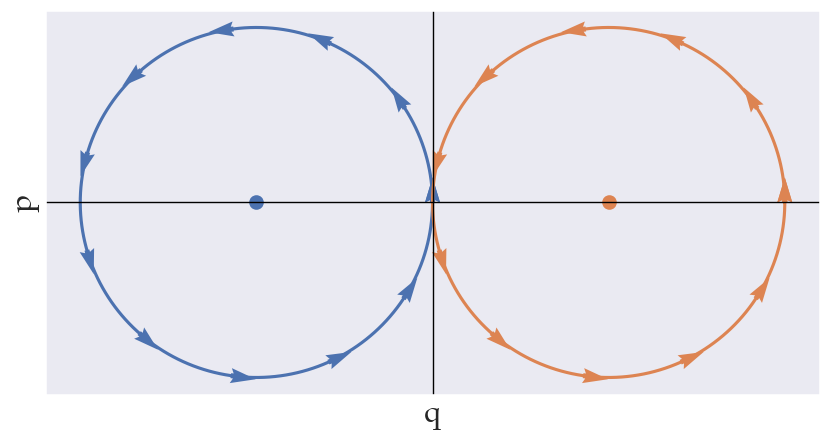

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# -----------------------
# Styling
# -----------------------
sns.set_theme(
    style="darkgrid",
    context="talk",
    font_scale=1.2,
    font="Palatino"
)

# Parameter for the circles
theta = np.linspace(0, 2*np.pi, 400)
radius = 1.5
centers = [(-1.5, 0), (1.5, 0)]
palette = sns.color_palette()
plt.figure(figsize=(10, 5))

i=0
for cx, cy in centers:
    # Circle
    x = cx + radius * np.cos(theta)
    y = cy + radius * np.sin(theta)
    plt.plot(x, y, color=palette[i])

    # Choose points where arrows will be drawn
    arrow_idx = np.linspace(0, len(theta) - 1, 12, dtype=int)

    # Tangent vectors (direction of walking)
    dx = -radius * np.sin(theta[arrow_idx])
    dy =  radius * np.cos(theta[arrow_idx])

    # Draw arrows
    plt.quiver(
        x[arrow_idx],
        y[arrow_idx],
        dx,
        dy,
        angles='xy',
        scale_units='xy',
        scale=7,
        color=palette[i],
        width=0.01
    )
    i+=1
plt.scatter([-1.5], [0], color=palette[0])
plt.scatter([1.5], [0], color=palette[1])
# Axes styling
plt.xticks([])
plt.yticks([])
plt.axhline(0, linewidth=1, color='black')
plt.axvline(0, linewidth=1, color='black')
#plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel("q")
plt.ylabel("p")

plt.savefig('../figs/B_gate_1.pdf', bbox_inches='tight')
plt.show()


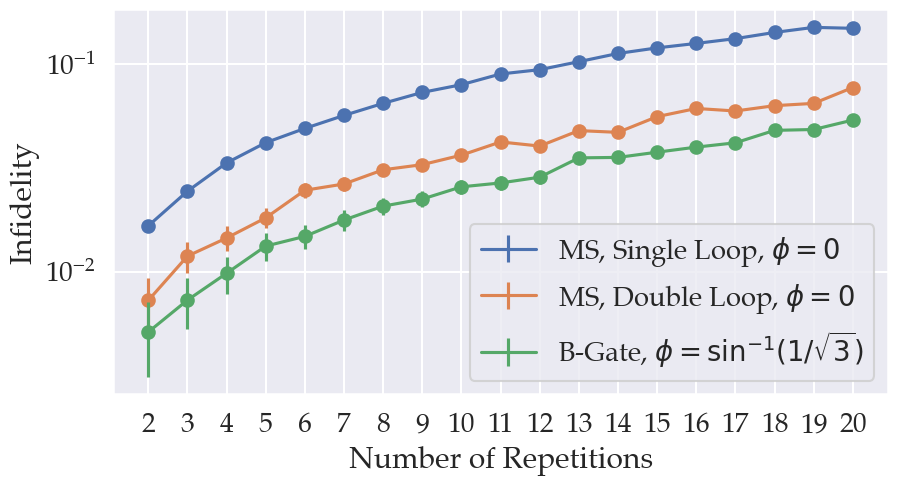

In [9]:
plt.figure(figsize=(10, 5))

MS_1 = [1-(0.997218 + np.random.randn()*0.0001/2)**(3*p) for p in range(1, 21)]
MS_2 = [1-(0.998727 + np.random.randn()*0.0001/2)**(3*p) for p in range(1, 21)]
B_   = [1-(0.998727 + np.random.randn()*0.0001/2)**(2*p) for p in range(1, 21)]


plt.scatter(range(2, 21), MS_1[1:])
plt.errorbar(range(2, 21), MS_1[1:], yerr=np.array([[0.001, 0.001] for p in range(2, 21)]).T, label=r"MS, Single Loop, $\phi=0$")
plt.errorbar(range(2, 21), MS_2[1:], yerr=np.array([[0.002, 0.002] for p in range(2, 21)]).T, label=r"MS, Double Loop, $\phi=0$")
plt.scatter(range(2, 21), MS_2[1:])
plt.errorbar(range(2, 21), B_[1:], yerr=np.array([[0.002, 0.002] for p in range(2, 21)]).T, label=r"B-Gate, $\phi=\text{sin}^{-1}(1/\sqrt{3})$")
plt.scatter(range(2, 21), B_[1:])
plt.yscale('log')
plt.yticks([1e-1, 1e-2])
plt.xticks(range(2, 21))
plt.xlabel("Number of Repetitions")
plt.ylabel("Infidelity")
plt.legend()
plt.savefig('../figs/B_gate_2.pdf', bbox_inches='tight')
